In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from adjustText import adjust_text
from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

matplotlib.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'

In [3]:
df_hr = pd.read_csv('../data/sample-physiology-waveform-Hr.csv', parse_dates=['CreateTime'])
df_hr.head()

,Hr,CreateTime
0,NaN,2023-12-13 16:39:00
1,NaN,2023-12-13 16:40:00
2,NaN,2023-12-13 16:41:00
3,NaN,2023-12-13 16:42:00
4,NaN,2023-12-13 16:43:00


In [4]:
df_spo2 = pd.read_csv('../data/sample-physiology-waveform-SpO2.csv', parse_dates=['CreateTime'])
df_spo2.head()

,SpO2,CreateTime
0,100.0,2023-12-13 16:39:00
1,100.0,2023-12-13 16:40:00
2,100.0,2023-12-13 16:41:00
3,100.0,2023-12-13 16:42:00
4,100.0,2023-12-13 16:43:00


In [5]:
# preprocess data
get_minute = lambda x: x.minute + x.hour * 60
df_hr['phy_time'] = df_hr['CreateTime'].apply(get_minute)
df_spo2['phy_time'] = df_spo2['CreateTime'].apply(get_minute)

hr_ts = df_hr.loc[df_hr['Hr'].notna(), 'phy_time'].to_numpy().reshape(-1, 1)
spo2_ts = df_spo2.loc[df_spo2['SpO2'].notna(), 'phy_time'].to_numpy().reshape(-1, 1)

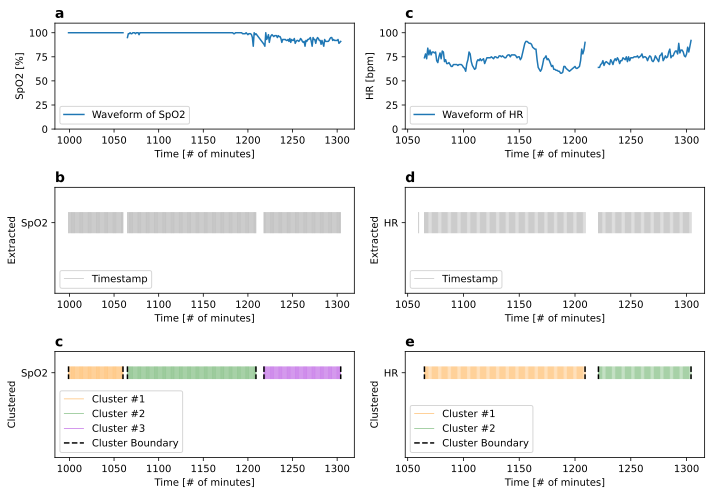

In [7]:
# plotting
cs = ['darkorange', 'forestgreen', 'darkviolet', 'royalblue']

fig, ax = plt.subplots(3, 2, figsize=[10, 7], dpi=300)
fig.set_facecolor('white')

# SpO2

ax[0,0].plot(df_spo2['phy_time'], df_spo2['SpO2'], label='Waveform of SpO2')
ax[0,0].set_ylim([0,110])
ax[0,0].set_ylabel('SpO2 [%]')
ax[0,0].set_xlabel('Time [# of minutes]')
ax[0,0].legend()

ax[1,0].eventplot(spo2_ts.reshape(1, -1), colors='grey', linelengths=0.06, linewidths=0.4, label='Timestamp')
ax[1,0].set_ylim([0.8,1.1])
ax[1,0].set_ylabel('Extracted')
ax[1,0].set_xlabel('Time [# of minutes]')
ax[1,0].set_yticks([1], ['SpO2'])
ax[1,0].legend(loc='lower left')

db = DBSCAN(eps=1, min_samples=2).fit(spo2_ts)
phy_labels = db.labels_
ext_events = []
for i, label in enumerate(set(phy_labels)):
    if label == -1: # drop noise
        continue
    gp = spo2_ts[phy_labels == label].reshape(1, -1)
    ext_events.extend([gp[0][0], gp[0][-1]])
    ax[2,0].eventplot(gp, colors=cs[i], linelengths=0.06, linewidths=0.4, label=f'Cluster #{i+1}')
ax[2,0].eventplot(ext_events, colors='black', linelengths=0.06, linestyles='dashed', label='Cluster Boundary')

ax[2,0].set_ylim([0.6, 1.1])
ax[2,0].set_ylabel('Clustered')
ax[2,0].set_xlabel('Time [# of minutes]')
ax[2,0].set_yticks([1], ['SpO2'])
ax[2,0].legend(loc='lower left')


# HR - Heart rate
ax[0,1].plot(df_hr['phy_time'], df_hr['Hr'], label='Waveform of HR')
ax[0,1].set_ylim([0,110])
ax[0,1].set_ylabel('HR [bpm]')
ax[0,1].set_xlabel('Time [# of minutes]')
ax[0,1].legend()

ax[1,1].eventplot(hr_ts.reshape(1, -1), colors='grey', linelengths=0.06, linewidths=0.4, label='Timestamp')
ax[1,1].set_ylim([0.8,1.1])
ax[1,1].set_ylabel('Extracted')
ax[1,1].set_xlabel('Time [# of minutes]')
ax[1,1].set_yticks([1], ['HR'])
ax[1,1].legend(loc='lower left')

db = DBSCAN(eps=1, min_samples=2).fit(hr_ts)
phy_labels = db.labels_
ext_events = []
for i, label in enumerate(set(phy_labels)):
    if label == -1: # drop noise
        continue
    gp = hr_ts[phy_labels == label].reshape(1, -1)
    ext_events.extend([gp[0][0], gp[0][-1]])
    ax[2,1].eventplot(gp, colors=cs[i], linelengths=0.06, linewidths=0.4, label=f'Cluster #{i+1}')
ax[2,1].eventplot(ext_events, colors='black', linelengths=0.06, linestyles='dashed', label='Cluster Boundary')

ax[2,1].set_ylim([0.6, 1.1])
ax[2,1].set_xlim(ax[1,1].get_xlim())
ax[2,1].set_ylabel('Clustered')
ax[2,1].set_xlabel('Time [# of minutes]')
ax[2,1].set_yticks([1], ['HR'])
ax[2,1].legend(loc='lower left')

# plot figure labels
for i in range(2):
    for j in range(3):
        ax[j,i].text(0, 1.05, f'{chr(97 + i * 2 + j)}', transform=ax[j,i].transAxes, fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig(f'../figures/meso-clustering_process.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'../figures/meso-clustering_process.svg', dpi=300, bbox_inches='tight')
plt.show()